In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Wedge, Polygon
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
import shapely.geometry as geom
from shapely.geometry import Point
import scipy.stats as ss
import sqlalchemy as sqla
import sqlite3
plt.rcParams['figure.figsize'] = (12, 12)
plt.style.use('ggplot')
%matplotlib inline

# Assignment 6

In this assignment, you'll analyze a collection of data sets from the [San Francisco Open Data Portal](http://data.sfgov.org/) and [Zillow](https://www.zillow.com/). The data sets have been stored in the SQLite database `sf_data.sqlite`, which you can [download here](http://anson.ucdavis.edu/~nulle/sf_data.sqlite). The database contains the following tables:

Table                   | Description
----------------------- | -----------
`crime`                 | Crime reports dating back to 2010.
`mobile_food_locations` | List of all locations where mobile food vendors sell.
`mobile_food_permits`   | List of all mobile food vendor permits. More details [here](https://data.sfgov.org/api/views/rqzj-sfat/files/8g2f5RV4PEk0_b24iJEtgEet9gnh_eA27GlqoOjjK4k?download=true&filename=DPW_DataDictionary_Mobile-Food-Facility-Permit.pdf).
`mobile_food_schedule`  | Schedules for mobile food vendors.
`noise`                 | Noise complaints dating back to August 2015.
`parking`               | List of all parking lots.
`parks`                 | List of all parks.
`schools`               | List of all schools.
`zillow`                | Zillow rent and housing statistics dating back to 1996. More details [here](https://www.zillow.com/research/data/).

The `mobile_food_` tables are explicitly connected through the `locationid` and `permit` columns. The other tables are not connected, but you may be able to connect them using dates, latitude/longitude, or postal codes.

Shapefiles for US postal codes are available [here](https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html). These may be useful for converting latitude/longitude to postal codes.

Shapefiles for San Francisco Neighborhoods are available [here](https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4).

__Exercise 1.1.__ Which mobile food vendor(s) sells at the most locations?

In [2]:
conn3 = sqlite3.connect("sf_data.sqlite")

In [3]:
query = """select "Applicant", count(*) as count from mobile_food_permits  
    group by "Applicant" order by count DESC """
vendor_counts = pd.read_sql_query(query,conn3)

In [5]:
vendor_counts.head()

,Applicant,count
0,Roadside Rotisserie Corporation / Country Grill,7
1,"San Francisco Carts & Concessions, Inc. DBA St...",6
2,"Halal Cart, LLC",5
3,"Off the Grid Services, LLC",5
4,"San Francisco Street Foods, Inc.",5


Roadside __Rotisserie Corporation__ and __San Francisco Carts and Concessions__ sell at the most locations, with 7 and 6 locations, respectively. Closely behind are Halal Cart, Off the Grid Services, San Francisco Street Foods, and The New York Frankfurter Co, with 5 locations each. 

__Exercise 1.2.__ Ask and use the database to analyze 5 questions about San Francisco. For each question, write at least 150 words and support your answer with plots. Make a map for at least 2 of the 5 questions.

You should try to come up with some questions on your own, but these are examples of reasonable questions:

* Which parts of the city are the most and least expensive?
* Which parts of the city are the most dangerous (and at what times)?
* Are noise complaints and mobile food vendors related?
* What are the best times and places to find food trucks?
* Is there a relationship between housing prices and any of the other tables?

Please make sure to clearly state each of your questions in your submission.

__My Questions:__ Answers are at the end of the notebook.
1. Is there a relationship between mobile food vendor location and housing prices?
2. Is there a relationship between mobile food vendor location and crime?
3. Are mobile food vendors located in areas with a high number parking lots?
4. Is there a relationshop between noise complaints, housing prices, and crime?
5. Where are the largest concentrations of mobile food vendors?

__First, we must make queries to obtain the necessary dataframes for analysis.__

In [5]:
housing = pd.read_sql_query("""select * from zillow""",conn3)
housing = housing.rename(columns={'RegionName': 'ZCTA5CE10'})

In [6]:
housing.head(3)

,ZCTA5CE10,Date,ZriPerSqft_AllHomes,MedianSoldPricePerSqft_AllHomes,PriceToRentRatio_AllHomes,Turnover_AllHomes
0,94109,2010-11-01 00:00:00,3.156,675.1913,19.14,6.0771
1,94110,2010-11-01 00:00:00,2.566,599.6785,18.10,5.4490
2,94122,2010-11-01 00:00:00,2.168,495.4432,17.99,2.4198


In [7]:
food_loc = pd.read_sql_query("""select * from mobile_food_locations where "Latitude" != 0""",conn3)
food_loc = food_loc.rename(columns={'Latitude': 'Lat', 'Longitude': 'Lon'})

In [8]:
food_loc.head(3)

,locationid,LocationDescription,Address,Lat,Lon
0,762182,TOWNSEND ST: 05TH ST to 06TH ST (400 - 499),444 TOWNSEND ST,37.774871,-122.398532
1,437211,MISSOURI ST: 20TH ST to SIERRA ST (500 - 630),555 MISSOURI ST,37.759304,-122.395902
2,765880,17TH ST: SAN BRUNO AVE to UTAH ST (2200 - 2299),2222 17TH ST,37.765216,-122.406007


In [9]:
parking = pd.read_sql_query("""select * from parking""",conn3)

In [10]:
parking.head(3)

,Owner,Address,PrimeType,SecondType,GarOrLot,RegCap,ValetCap,MCCap,LandType,Lat,Lon
0,Private,2110 Market St,PPA,,L,13,0,0,restaurant,37.767378,-122.429344
1,SFMTA,993 Potrero,PPA,,L,34,0,0,,37.757272,-122.406320
2,Port of SF,601 Terry A Francois Blvd,PPA,,L,72,0,0,,37.770135,-122.385801


In [11]:
noise = pd.read_sql_query("""select * from noise where "Lat" != "NaN" or 0 """,conn3) 

In [12]:
noise.head(3)

,CaseID,Type,Address,Neighborhood,Datetime,Lat,Lon
0,6446138,amplified_sound_electronics,Intersection of CLINTON PARK and GUERRERO ST,Mission Dolores,2016-10-21 13:20:18,37.769148,-122.424475
1,5929789,other_excessive_noise,"1301 48TH AVE, SAN FRANCISCO, CA, 94122",Outer Sunset,2016-06-01 11:38:59,37.762047,-122.508365
2,5659943,other_excessive_noise,"736 LEAVENWORTH ST, SAN FRANCISCO, CA, 94109",Lower Nob Hill,2016-03-13 01:18:27,37.787983,-122.414943


In [13]:
crime = pd.read_sql_query("""select * from crime where "Lat" != "NaN" or 0 """,conn3)

In [14]:
crime.head(3)

,IncidntNum,Category,Descript,DayOfWeek,Datetime,PdDistrict,Resolution,Address,Lon,Lat
0,150060275,NON-CRIMINAL,LOST PROPERTY,Monday,2015-01-19 14:00:00,MISSION,NONE,18TH ST / VALENCIA ST,-122.421582,37.761701
1,150098210,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,2015-02-01 15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191
2,150098210,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Sunday,2015-02-01 15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191


__Here we use the shapefile of zip codes from the US Census to get a dataframe of zip codes for analysis__

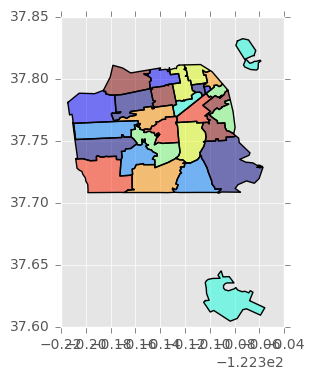

In [15]:
zips = gpd.read_file("cb_2015_us_zcta510_500k/cb_2015_us_zcta510_500k.shp")
zips = zips[zips.ZCTA5CE10.isin(['94102','94103','94104','94105','94107','94108','94109','94110','94111','94112','94114','94115','94116','94117','94118','94121','94122','94123','94124','94127','94128','94129','94130','94131','94132','94133','94134','94143','94158','94188'
])]
zips.plot()

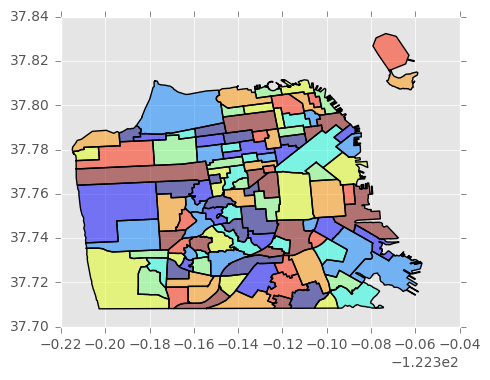

In [16]:
hoods = gpd.read_file("SF_Find_Neighborhoods/geo_export_792e17e9-ffbb-4d29-b6f3-a889540169fc.shp")
hoods.plot()

Since the neighborhood data doesn't perfectly align with the zipcodes, we will choose one for our analysis. Let's continue with zip codes. 

__We have to do some editing of the housing data since it doesn't include latitude and longitude data__

In [17]:
zips_sub = zips[['ZCTA5CE10','geometry']]
zips_sub = zips_sub.set_index('ZCTA5CE10')

In [18]:
housing = housing.groupby('ZCTA5CE10').sum()
housing = housing.reset_index()
housing['ZCTA5CE10'] = housing['ZCTA5CE10'].apply(lambda x: str(x).decode('utf-8'))
housing = housing.join(zips_sub, on = 'ZCTA5CE10')

__Now let's look at where the mobile food vendors are located__

In [19]:
food_loc_points = food_loc[['Lon', 'Lat']].apply(lambda row: Point(row["Lon"], row["Lat"]), axis=1)
geo_food_loc = gpd.GeoDataFrame({"geometry": food_loc_points})

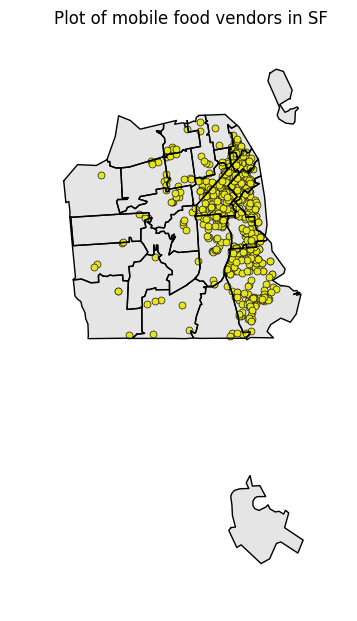

In [20]:
geo_food_loc.crs = {'init': 'epsg:4326'}
plt.style.use("default")
%matplotlib inline
fig, ax = plt.subplots(1, figsize=(3.5,7))
base = zips.plot(ax=ax, color='gray', alpha=0.2)
geo_food_loc.plot(ax=base, marker="o", mfc="yellow", markersize=5, markeredgecolor="black", zorder=0)
_ = ax.axis('off')
ax.set_title("Plot of mobile food vendors in SF")

__Let's look at a concentration map so that we can compare it easily with other data__

In [21]:
food_vendors = gpd.tools.sjoin(geo_food_loc, zips, how="right", op='intersects')
num_vendors_per_zip = food_vendors.groupby('ZCTA5CE10').size()
num_vendors_per_zip = num_vendors_per_zip.to_frame(name="vendor_num").reset_index()

In [22]:
num_vendors_per_zip.sort_values(by = "vendor_num", ascending = False).head()

,ZCTA5CE10,vendor_num
18,94124,159
4,94107,117
1,94103,86
3,94105,72
7,94110,45


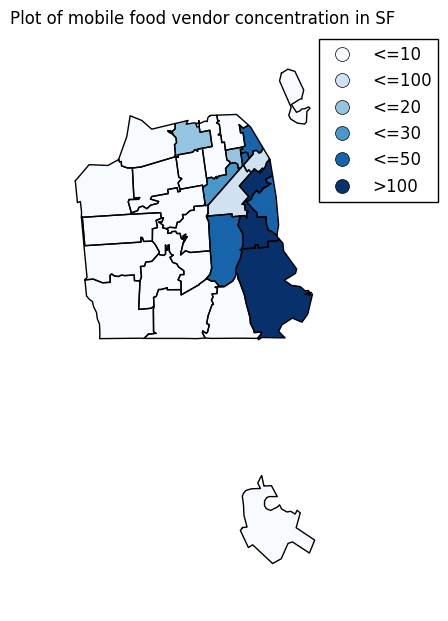

In [23]:
num_vendors_per_zip["quant_cuts"] = pd.cut(num_vendors_per_zip["vendor_num"], bins=[0, 10, 20, 30, 50, 100, 160], 
              labels=["<=10", "<=20", "<=30","<=50", "<=100", ">100"])
food_vendors_num = pd.merge(zips, num_vendors_per_zip, on="ZCTA5CE10", how="right")
fig, ax = plt.subplots(1, figsize=(3.5,7))
food_vendors_num.plot(ax=ax, column='quant_cuts', cmap='Blues', alpha=1, legend=True)
_ = ax.axis('off')
ax.set_title("Plot of mobile food vendor concentration in SF")
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.9, 0.5, 0.5, 0.5))

__Now let's look at a concentration map of parking lots by zip code.__

In [24]:
parking_points = parking[['Lon', 'Lat']].apply(lambda row: Point(row["Lon"], row["Lat"]), axis=1)
geo_parking = gpd.GeoDataFrame({"geometry": parking_points})
parking_lots = gpd.tools.sjoin(geo_parking, zips, how="right", op='intersects')
num_lots_per_zip = parking_lots.groupby('ZCTA5CE10').size()
num_lots_per_zip = num_lots_per_zip.to_frame(name="lot_num").reset_index()

In [25]:
num_lots_per_zip.sort_values(by = "lot_num", ascending = False).head()

,ZCTA5CE10,lot_num
1,94103,165
4,94107,116
18,94124,108
7,94110,98
0,94102,78


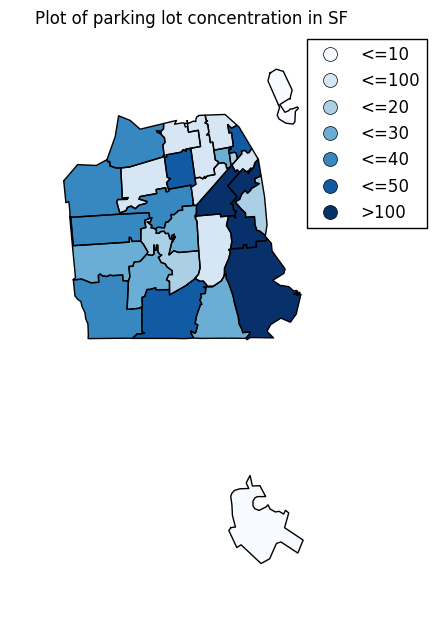

In [26]:
num_lots_per_zip["quant_cuts"] = pd.cut(num_lots_per_zip["lot_num"], bins=[0, 10, 20, 30, 40, 50, 100, 200], 
              labels=["<=10", "<=20", "<=30","<=40", "<=50", "<=100", ">100"])
parking_lot_num = pd.merge(zips, num_lots_per_zip, on="ZCTA5CE10", how="right")
fig, ax = plt.subplots(1, figsize=(3.5,7))
parking_lot_num.plot(ax=ax, column='quant_cuts', cmap='Blues', alpha=1, legend=True)
_ = ax.axis('off')
ax.set_title("Plot of parking lot concentration in SF")
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.9, 0.5, 0.5, 0.5))

__Below is the concentration map of noise complaints by zip code since 2015.__

In [27]:
noise_points = noise[['Lon', 'Lat']].apply(lambda row: Point(row["Lon"], row["Lat"]), axis=1)
geo_noise = gpd.GeoDataFrame({"geometry": noise_points})
noise_comp = gpd.tools.sjoin(geo_noise, zips, how="right", op='intersects')
num_noise_per_zip = noise_comp.groupby('ZCTA5CE10').size()
num_noise_per_zip = num_noise_per_zip.to_frame(name="noise_num").reset_index()

In [44]:
num_noise_per_zip.sort_values(by = "noise_num", ascending = False).head()

,ZCTA5CE10,noise_num,quant_cuts
7,94110,487,>500
1,94103,461,>500
6,94109,415,>500
0,94102,284,<=300
16,94122,251,<=300


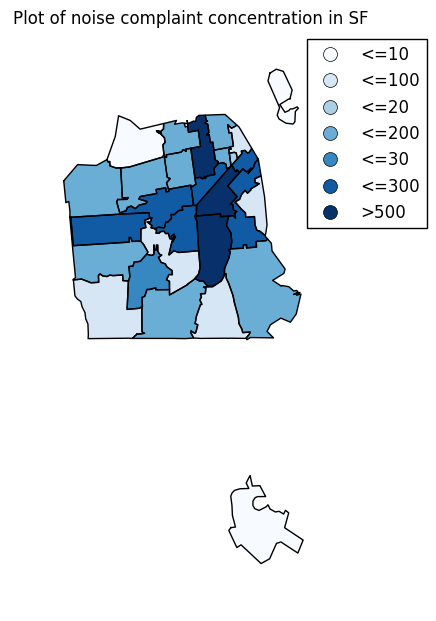

In [29]:
num_noise_per_zip["quant_cuts"] = pd.cut(num_noise_per_zip["noise_num"], bins=[0, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500], 
              labels=["<=10", "<=20", "<=30","<=40", "<=50", "<=100", "<=200", "<=300", "<=400", ">500"])
noise_num = pd.merge(zips, num_noise_per_zip, on="ZCTA5CE10", how="right")
fig, ax = plt.subplots(1, figsize=(3.5,7))
noise_num.plot(ax=ax, column='quant_cuts', cmap='Blues', alpha=1, legend=True)
_ = ax.axis('off')
ax.set_title("Plot of noise complaint concentration in SF")
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.9, 0.5, 0.5, 0.5))

__Below is the concentration map of crimes by zip code since 2010__

In [30]:
crime_points = crime[['Lon', 'Lat']].apply(lambda row: Point(row["Lon"], row["Lat"]), axis=1)
geo_crime = gpd.GeoDataFrame({"geometry": crime_points})
crime_comp = gpd.tools.sjoin(geo_crime, zips, how="right", op='intersects')
num_crime_per_zip = crime_comp.groupby('ZCTA5CE10').size()
num_crime_per_zip = num_crime_per_zip.to_frame(name="crime_num").reset_index()

In [42]:
num_crime_per_zip.sort_values(by = "crime_num", ascending = False).head()

,ZCTA5CE10,crime_num,quant_cuts
1,94103,167434,>100000
0,94102,115068,>100000
7,94110,102106,>100000
6,94109,74086,<=100000
18,94124,67071,<=70000


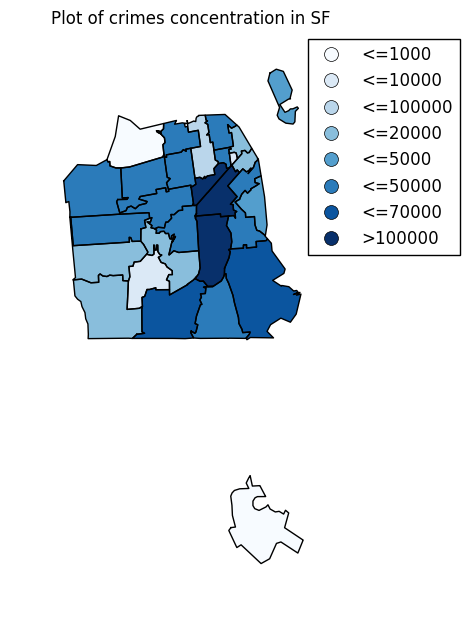

In [32]:
num_crime_per_zip["quant_cuts"] = pd.cut(num_crime_per_zip["crime_num"], bins=[0, 1000, 5000, 10000, 20000, 50000, 70000, 100000, 170000], 
              labels=["<=1000", "<=5000", "<=10000","<=20000", "<=50000", "<=70000", "<=100000", ">100000"])
crime_num = pd.merge(zips, num_crime_per_zip, on="ZCTA5CE10", how="right")
fig, ax = plt.subplots(1, figsize=(3.5,7))
crime_num.plot(ax=ax, column='quant_cuts', cmap='Blues', alpha=1, legend=True)
_ = ax.axis('off')
ax.set_title("Plot of crimes concentration in SF")
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.9, 0.5, 0.5, 0.5))

__Below is the housing price by zip code, measured using Zillow's "zri per sq foot" formula. The higher the number, the more expensive the housing is.__

In [34]:
housing_cost_per_zip = housing[['ZCTA5CE10','ZriPerSqft_AllHomes']]
housing_cost_per_zip = housing_cost_per_zip.fillna(1)
housing_cost_per_zip['ZriPerSqft_AllHomes'] = housing_cost_per_zip['ZriPerSqft_AllHomes'].astype(int)

In [40]:
housing_cost_per_zip.sort_values(by = 'ZriPerSqft_AllHomes', ascending = False).head()

,ZCTA5CE10,ZriPerSqft_AllHomes,quant_cuts
4,94105,320,>350
6,94108,311,>350
1,94102,298,<=300
23,94133,292,<=300
7,94109,288,<=300


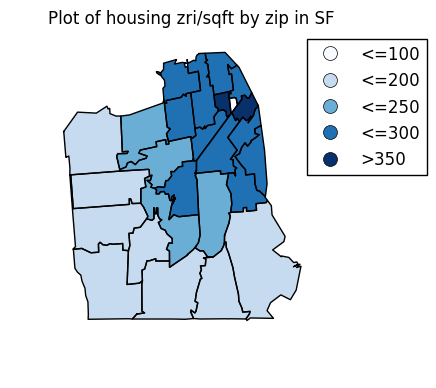

In [36]:
housing_cost_per_zip["quant_cuts"] = pd.cut(housing_cost_per_zip["ZriPerSqft_AllHomes"], bins=[0, 100, 150, 200, 250, 300, 350], 
              labels=["<=100", "<=150", "<=200","<=250", "<=300", ">350"])
housing_cost = pd.merge(zips, housing_cost_per_zip, on="ZCTA5CE10", how="right")
housing_cost = housing_cost.drop(25)
fig, ax = plt.subplots(1, figsize=(3.5,4))
housing_cost.plot(ax=ax, column='quant_cuts', cmap='Blues', alpha=1, legend=True)
_ = ax.axis('off')
ax.set_title("Plot of housing zri/sqft by zip in SF")
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.9, 0.5, 0.5, 0.5))

__1. Is there a relationship between mobile food vendor location and housing prices?__  
Most of the mobile food vendors are located in the North East portion of the city. The top two zip codes are 94124 and 94107, with 159 and 117 mobile food vendors, respectively. Following close behind are 94103 and 94105, with 86 and 72 mobile food vendors, respectively.  
Regarding housing prices, the most expensive zip codes are 94105, 94108, 94102, 94133, 94109, with very similar zri/sq foot prices. There is only one zip code in common here and it is the most expensive zip code at 320/sqft. However, it doesn't seem that mobile food vendors are commonly located in expensive areas.  
Let's look at where the zip codes containing the most mobile food vendors fall. The most common zip code for mobile food vendors is 94124, which is almost the least expensive zip code at 174/sqft, and 94107 is in the top 10 at 274/sqft, so it is significantly more expensive than 94124. Zip code 94103 is at 275/sqft.  
So it seems that there isn't a strong relationship between mobile food vendor location and housing prices. 

__2. Is there a relationship between mobile food vendor location and crime?__  
The zip codes with the highest concentration of crime are 94103, 94102, and 94110. Zip code 94103 has a high number of mobile food vendors, but it is not top of the list. The two zip codes with highest numbers of mobile food vendors ( 94124, and 94107) are in the top 10 regarding crime concentration, but 94105 is low on the list.  
Overall, it appears that there may be a correlation between vendor location and crime. This may be due to the fact that mobile food vendors choose locations that are highly populated or have a lot of foot traffic. It would make sense that areas like this would also have higher occurrences of crime. 

__3. Are mobile food vendors located in areas with a high number parking lots?__  
The zip codes with the highest concentration of parking lots are 94103, 94107, 94124, 94110, and 94102. There is clear overlap here since 94107, 94124, and 94103 all have high concentrations of mobile food vendors. 
So there is a clear correlation, but this may be due to other factors, such as concentration of shopping or office buildings. Both of these could cause more parking lots to be built, and would attract mobile food vendors.  
We could analyze concentrations of businesses and shopping to get a better idea of how these are all related. 

__4. Is there a relationshop between noise complaints, housing prices, and crime?__  
The zip codes with the highest concentration of noise complaints are 94110, 94103, 94109, 94102, and 94122. The zip codes with the highest concentration of crime are 94103, 94102, 94110, 94109, and 94124. The most expensive zip codes are 94105, 94108, 94102, 94133, and 94109. Looking at the maps, you can see the clear overlap between some of the zip codes for crime and noise complaints: 94110, 94103, 94109, and 94102, so there is a clear relationship between noise compaints and crime. You can also see on the maps of crime and noise concentrations that even the zip codes with lower concentrations align pretty well.  
Regarding housing, there is not a clear positive relationship, but perhaps there is an inverse relationship. We can look at the housing prices for the zip codes with the highest concentrations of noise and crime:  
* 94110: 235/sqft (middle of the road)
* 94103: 275/sqft (middle of the road)
* 94109: 288/sqft (higher price)
* 94102: 298/sqft (hiher price)
* 94124: 174/sqft (lower price)
* 94122: 178/sqft (lower price)  
The last two zip codes did not overlap between noise and crime complaints, and were in the middle of the other's list (high in on ascpect, middle in the other). It appears that more crimes were reported and more noise complaints were filed in middle to higher priced neibhorhoods. This aligns with expected behaviors of people in higher priced neighborhoods. Typically, people do not call police as frequently in lower priced neighborhoods.  
To analyze our findings at a deeper level, we could analyze the type of crimes being reported and the type of noise complaints, the outcome of the noise complaint (if it was resolved).

__5. Where are the largest concentrations of mobile food vendors?__  
The zip codes with the largest concentrations of mobile food trucks are 94124, 94107, 94103, 94105, and 94110. These are primarily located on the West side of the city, near the bay. There are apartments, parks, AT&T park, piers, and shopping. These zip codes are all near (or include) the mission district, which has a very "hipster" vibe with a lot of coffee shops, thrift stores, and vegan restaurants.  
It would be interesting to look at demographics of these zip codes as well. Since eating at mobile food trucks are becoming a popular recreational activity, it would be helpful to learn about the demographics of the customers. We could also plot office buildings and compare with the time of day that mobile food vendors are scheduled. Some may be during lunch time and others in the evenings. Another interesting analysis would be to compare mobile food vendor location to brewery locations, as this seems to be a common pairing for breweries. 